In [1]:
pip install pystan

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from pprint import pprint
import pystan
from scipy.special import expit
from matplotlib import pyplot as plt
from numpy.random import normal, randint, binomial, choice
from numpy import percentile, concatenate, array, linspace, append
%matplotlib inline

Text(0.5, 1.0, 'The logistic function')

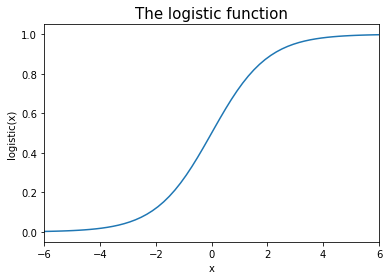

In [3]:
x_axis = linspace(-10, 10, 100)
plt.plot(x_axis, expit(x_axis))
plt.xlabel('x')
plt.xlim([-6, 6])
plt.ylabel('logistic(x)')
plt.title('The logistic function', fontsize=15)

# Binary IRT Model

In [4]:
binary_irt_model = pystan.StanModel(file="C:\\Users\\tangw\\Desktop\\ICE\\binary_irt.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dbddecf477730252fdf914d6bda8cdbb NOW.


DistutilsPlatformError: Unable to find vcvarsall.bat

In [ ]:
def generate_binary_irt_data(sim_input):
    # simulate abilities, difficulties, and subject/item combinations
    sim_ability = normal(loc=0,
                         scale=sim_input['sigma_ability'],
                         size=sim_input['S'])
    sim_difficulty = normal(loc=sim_input['mu_difficulty'],
                            scale=sim_input['sigma_difficulty'],
                            size=sim_input['I'])
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['R'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['R'])
    # work out success probabilities
    sim_success_probabilities = expit(sim_ability[sim_subject] -
                                      sim_difficulty[sim_item])
    # simulate grades
    sim_grade = binomial(n=1,
                         p=sim_success_probabilities,
                         size=sim_input['R'])
    # Dictionary of data to give to STAN
    sim_data = {
        'grade': sim_grade,
        'subject': sim_subject + 1,
        'item': sim_item + 1,
    }
    sim_data.update({i: binary_sim_input[i] for i in ['R', 'I', 'S']})
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: binary_sim_input[i] for i in ['sigma_ability',
                                                          'mu_difficulty',
                                                          'sigma_difficulty']})
    return sim_data, recoverables

# define some input data
binary_sim_input = {'R': 10000,
                    'I': 15,
                    'S': 15,
                    'sigma_ability': 1,
                    'sigma_difficulty': 2,
                    'mu_difficulty': -1}
binary_sim_data, binary_sim_recoverables = generate_binary_irt_data(binary_sim_input)
# print results
print('Here is our randomly generated data:')
pprint(binary_sim_data)  # pprint makes the dictionary print nicely

In [ ]:
#Stimulate data next
# fit model
binary_fit = binary_irt_model.sampling(data=binary_sim_data, iter=2000, chains=4)
# extract parameters
binary_params = binary_fit.extract()
# print fit summary
print(binary_fit)
# draw summary plot
f = binary_fit.plot()
f.set_size_inches(18, 10)
plt.tight_layout()

In [ ]:
# define some names for convenience
binary_sim_ability = binary_sim_recoverables['ability']
binary_sim_difficulty = binary_sim_recoverables['difficulty']
# Work out upper and lower quantiles
binary_ability_quantiles = percentile(binary_params['ability'], [5, 95], axis=0)
binary_difficulty_quantiles = percentile(binary_params['difficulty'], [5, 95], axis=0)
# draw Graphs
f, ax = plt.subplots(2, 3, figsize=[12, 8])
ax = ax.ravel()
f.suptitle('How well were the simultated parameters recovered?', y=1.03, fontsize=16)
# ability
ax[0].set_xlabel('simulator ability parameter')
ax[0].set_ylabel('posterior 90% interval and mean')
ax[0].errorbar(binary_sim_ability, 
               binary_params['ability'].mean(axis=0),
               yerr=abs(binary_params['ability'].mean(axis=0) - binary_ability_quantiles),
               fmt='o')
ax[0].plot(binary_sim_ability, binary_sim_ability, color='r')
ax[0].legend(['y=x'], prop={'size': 10})
# difficulty
ax[1].set_xlabel('simulator difficulty parameter')
ax[1].errorbar(binary_sim_difficulty,
               binary_params['difficulty'].mean(axis=0) + binary_params['mu_difficulty'].mean(),
               yerr=abs(binary_params['difficulty'].mean(axis=0) - binary_difficulty_quantiles),
               fmt='o')
ax[1].plot(binary_sim_difficulty, binary_sim_difficulty, color='r')
ax[1].legend(['y=x'], prop={'size': 10})
# mu_difficulty
ax[5].hist(binary_params['mu_difficulty'], alpha=0.8, bins=30)
ax[5].axvline(binary_sim_recoverables['mu_difficulty'], color='r')
ax[5].legend(['simulator mu_difficulty'], prop={'size': 10})
ax[5].set_xlabel('mu_difficulty value')
ax[5].set_ylabel('sampling frequency')
# sigma_difficulty
ax[4].hist(binary_params['sigma_difficulty'], alpha=0.8, bins=30)
ax[4].axvline(binary_sim_recoverables['sigma_difficulty'], color='r')
ax[4].legend(['simulator sigma_difficulty'], prop={'size': 10})
ax[4].set_xlabel('sigma_difficulty value')
# sigma_ability
ax[3].hist(binary_params['sigma_ability'], alpha=0.8, bins=30)
ax[3].axvline(binary_sim_recoverables['sigma_ability'], color='r')
ax[3].legend(['simulator sigma_ability'], prop={'size': 10})
ax[3].set_xlabel('sigma_ability value')

plt.tight_layout()

# Graded IRT model

In [ ]:
# compile the model
graded_irt_model = pystan.StanModel(file="graded_irt.stan")

In [ ]:
# pmf for the ordered logistic distribution
def get_ordered_logistic_probs(ability, item_difficulties):
    # NB the '+' operators here represent list concatenation not addition
    return array([1 - expit(ability - item_difficulties[0])] +
                  [expit(ability - item_difficulties[grade - 1]) - 
                   expit(ability - item_difficulties[grade])
                   for grade in range(1, len(item_difficulties))] +
                  [expit(ability - item_difficulties[len(item_difficulties) - 1])])

# function for generating graded irt data
def generate_graded_irt_data(sim_input):
    # abilities
    sim_ability = normal(loc=0,
                         scale=1,
                         size=sim_input['S'])
    # difficulty of the easiest grade for each item
    sim_first_difficulty = normal(loc=sim_input['mu_first_difficulty'],
                                  scale=sim_input['sigma_first_difficulty'],
                                  size=(sim_input['I'], 1))
    # size of steps from one grade to the next for each item
    sim_difficulty_steps = abs(normal(loc=0,
                                      scale=sim_input['sigma_step'],
                                      size=(sim_input['I'], sim_input['G']-2)))
    # cumulatively add first difficulties to steps to get overall difficulties
    sim_difficulty = append(sim_first_difficulty,
                            sim_difficulty_steps, 
                            axis=1).cumsum(axis=1)
    # assign subjects and items
    sim_subject = randint(low=0,
                          high=sim_input['S'],
                          size=sim_input['R'])
    sim_item = randint(low=0,
                       high=sim_input['I'],
                       size=sim_input['R'])
    # calculate outcome probabilities for each response
    sim_probs = [get_ordered_logistic_probs(*i) 
                 for i in zip(sim_ability[sim_subject], sim_difficulty[sim_item])]
    # generate random grades
    sim_grade = concatenate([choice(a=range(1, sim_input['G'] + 1),
                                    size=1,
                                    p=sim_probs[i]) 
                             for i in range(sim_input['R'])])
    # dictionary of data that we will give to Stan
    sim_data = {
        'subject': sim_subject + 1,
        'item': sim_item + 1,
        'grade': sim_grade
    }
    sim_data.update({i: sim_input[i] for i in ['R', 'I', 'S', 'G']})
    # dictionary of numbers we want to recover
    recoverables = {
        'ability': sim_ability,
        'difficulty': sim_difficulty,
    }
    recoverables.update({i: sim_input[i] for i in ['sigma_ability',
                                                   'sigma_first_difficulty',
                                                   'sigma_step',
                                                   'mu_first_difficulty']})
    return sim_data, recoverables

# Some input data
graded_sim_input = {'R': 10000,
                    'I': 5,
                    'S': 15,
                    'G': 4,
                    'sigma_ability': 1,
                    'sigma_first_difficulty': 2,
                    'sigma_step': 1.5,
                    'mu_first_difficulty': -1}
graded_sim_data, graded_sim_recoverables = generate_graded_irt_data(graded_sim_input)

In [ ]:
# fit model
graded_fit = graded_irt_model.sampling(data=graded_sim_data, iter=3000, chains=4)
# extract parameters
graded_params = graded_fit.extract()
# print fit summary
print(graded_fit)

In [ ]:
# work out quantiles
graded_ability_quantiles = percentile(graded_params['ability'], [5, 95], axis=0)
graded_difficulty_quantiles = [
    concatenate(i) for i in percentile(graded_params['difficulty'], [5, 95], axis=0)
]
# some convenience names
graded_ability_means = graded_params['ability'].mean(axis=0)
graded_difficulty_means = concatenate(graded_params['difficulty'].mean(axis=0))
graded_sim_ability = graded_sim_recoverables['ability']
graded_sim_difficulty = concatenate(graded_sim_recoverables['difficulty'])
# start drawing graphs                 
f, ax = plt.subplots(2, 3, figsize=(12, 8))
ax = ax.ravel()
f.suptitle('How well does the graded model recover simultated parameters?', y=1.03, fontsize=16)
# ability
ax[0].set_xlabel('real ability parameter')
ax[0].set_ylabel('posterior 90% interval and mean')
ax[0].errorbar(graded_sim_ability,
               graded_ability_means,
               yerr=abs(graded_ability_means - graded_ability_quantiles),
               fmt='o')
ax[0].plot(graded_sim_ability, graded_sim_ability, color='r')
ax[0].legend(['y=x'], prop={'size': 10})
# difficulty
ax[1].set_xlabel('simulator difficulty parameter')
ax[1].errorbar(graded_sim_difficulty, 
               graded_difficulty_means,
               yerr=abs(graded_difficulty_means - graded_difficulty_quantiles), 
               fmt='o')
ax[1].plot(graded_sim_difficulty, graded_sim_difficulty, color='r')
ax[1].legend(['y=x'], prop={'size': 10})
# sigma_step
ax[2].hist(graded_params['sigma_step'], alpha=0.8, bins=30)
ax[2].axvline(graded_sim_recoverables['sigma_step'], color='r')
ax[2].legend(['simulator sigma_step'], prop={'size': 10})
ax[2].set_xlabel('sigma_step value')
# sigma_ability
ax[3].hist(graded_params['sigma_ability'], alpha=0.8, bins=30)
ax[3].axvline(graded_sim_recoverables['sigma_ability'], color='r')
ax[3].legend(['simulator sigma_ability'], prop={'size': 10})
ax[3].set_xlabel('sigma_ability value')
# sigma_first_difficulty
ax[4].hist(graded_params['sigma_first_difficulty'], alpha=0.8, bins=30)
ax[4].axvline(graded_sim_recoverables['sigma_first_difficulty'], color='r')
ax[4].legend(['simulator sigma_first_difficulty'], prop={'size': 10})
ax[4].set_xlabel('sigma_first_difficulty value')
# mu_first_difficulty
ax[5].hist(graded_params['mu_first_difficulty'], alpha=0.8, bins=30)
ax[5].axvline(graded_sim_recoverables['mu_first_difficulty'], color='r')
ax[5].legend(['simulator mu_first_difficulty'], prop={'size': 10})
ax[5].set_xlabel('mu_first_difficulty value')
ax[5].set_ylabel('sampling frequency')

# Cross-validation

In [ ]:
# Compile the cross-validation model
graded_irt_model_xval = pystan.StanModel(file="graded_irt_xval.stan")
# Number of chunks to partition the data into:
n_folds = 5
whole_dataset = pd.DataFrame({i: graded_sim_data[i] 
                              for i in ['item', 'subject', 'grade']})
test_dataset = whole_dataset.copy()
predictions = pd.DataFrame([])
for fold in range(n_folds):
    test_data = test_dataset.sample(n=int(len(whole_dataset) / n_folds))
    training_data = whole_dataset.drop(test_data.index)
    this_fold_data = {'I': len(whole_dataset['item'].unique()),
                      'S': len(whole_dataset['subject'].unique()),
                      'G': len(whole_dataset['grade'].unique()),
                      'R': len(training_data),
                      'item': training_data['item'],
                      'subject': training_data['subject'],
                      'grade': training_data['grade'],
                      'R_holdout': len(test_data),
                      'item_holdout': test_data['item'],
                      'subject_holdout': test_data['subject']}
    this_fold_fit = graded_irt_model_xval.sampling(data=this_fold_data, iter=200, chains=4)
    this_fold_params = this_fold_fit.extract()
    this_fold_predictions = pd.DataFrame(this_fold_params['predicted_grade'].T,
                                         index=test_data.index)
    predictions = pd.concat([predictions, this_fold_predictions])
    test_dataset = test_dataset.drop(test_data.index)
predictions.sort_index(inplace=True)
predictions.columns = ['prediction_' + str(i) for i in predictions.columns]
output = whole_dataset.join(predictions)
output.head()

In [ ]:
mae = (pd.DataFrame([abs(output[i] - output['grade']) 
                     for i in output[predictions.columns]])
       .mean(axis=1)
       .mean())
mse = (pd.DataFrame([(output[i] - output['grade']) ** 2
                     for i in output[predictions.columns]])
       .mean(axis=1)
       .mean())
print('Mean absolute error: ' + str(mae) + '\nMean square error: ' + str(mse))